In [185]:
from pathlib import Path
import numpy as np
from ultralytics import YOLO
import supervision as sv
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from Functions import eval, AP, iou, plot
from PIL import Image
import warnings
import cv2
import rasterio
import seaborn as sns
from rasterio.errors import NotGeoreferencedWarning
warnings.simplefilter("ignore", NotGeoreferencedWarning)

In [186]:
model = YOLO(r'train/weights/best.pt')
test_dir = r'data/test/images'
test_images = list(Path(test_dir).glob('*.tif'))

In [187]:
preds = []
tgs = []

for img in test_images:
    with rasterio.open(img) as src:
        image = src.read([1, 2, 3])
        image = np.moveaxis(image, 0, -1)
    results = model(image)[0]
    pred_box = results.boxes.xyxy.cpu().numpy()
    pred_conf = results.boxes.conf.cpu().numpy()
    pred_cls = results.boxes.cls.cpu().numpy()
    if len(pred_box) > 0:
        pred_box = pred_box.reshape(-1, 4)
        pred_cls = pred_cls.reshape(-1, 1)
        pred_conf = pred_conf.reshape(-1, 1)
        pred = np.hstack((pred_box, pred_cls, pred_conf))
    else:
        pred_combined = np.zeros((0, 6))
        
    label = str(img).replace('images', 'labels').replace('.tif', '.txt')
    if not Path(label).exists():
        tg = np.zeros((0, 5))
    else:
        boxes = []
        with open(label, 'r') as f:
            for line in f:
                cls, x_center, y_center, width, height = map(float, line.strip().split())
                x_center *= image.shape[1]
                y_center *= image.shape[0]
                width *= image.shape[1]
                height *= image.shape[0]
                xmin = x_center - width/2
                ymin = y_center - height/2
                xmax = xmin + width
                ymax = ymin + height
                boxes.append([xmin, ymin, xmax, ymax, cls])
        tg = np.array(boxes) if boxes else np.zeros((0, 5))
    
    preds.append(pred)
    tgs.append(tg)


0: 416x416 7 sps, 111.2ms
Speed: 0.0ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 3 sps, 106.1ms
Speed: 1.0ms preprocess, 106.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 3 sps, 108.1ms
Speed: 2.0ms preprocess, 108.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 6 sps, 115.8ms
Speed: 0.0ms preprocess, 115.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 12 sps, 115.0ms
Speed: 3.0ms preprocess, 115.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 5 sps, 151.8ms
Speed: 0.4ms preprocess, 151.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 5 sps, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 4 sps, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 416)

0:

In [188]:
ious = [0.1, 0.3, 0.5, 0.7, 0.9]
confs = [0.1, 0.3, 0.5, 0.7, 0.9]
m = []

for iou in ious:
    for conf in confs:
        confusion_matrix = sv.ConfusionMatrix.from_tensors(
            predictions=preds,
            targets=tgs,
            classes=['solar_panel'],
            conf_threshold=conf,
            iou_threshold=iou
        )
        matrix = confusion_matrix.matrix
        TP = matrix[0, 0]
        FP = matrix[1, 0]
        FN = matrix[0, 1]
        
        pr = TP / (TP + FP) if (TP + FP) > 0 else 0
        rc = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (pr * rc) / (pr + rc) if (pr + rc) > 0 else 0
        
        m.append({
            'IoU': iou,
            'Conf': conf,
            'Precision': pr,
            'Recall': rc,
            'F1': f1
        })

df = pd.DataFrame(m)
print(df)

    IoU  Conf  Precision    Recall        F1
0   0.1   0.1   0.815847  0.758785  0.786282
1   0.1   0.3   0.839877  0.744456  0.789293
2   0.1   0.5   0.892301  0.684067  0.774430
3   0.1   0.7   0.924134  0.573524  0.707789
4   0.1   0.9   0.946009  0.137496  0.240095
5   0.3   0.1   0.807410  0.750938  0.778151
6   0.3   0.3   0.831794  0.737291  0.781697
7   0.3   0.5   0.886070  0.679290  0.769023
8   0.3   0.7   0.916987  0.569089  0.702316
9   0.3   0.9   0.943662  0.137155  0.239500
10  0.5   0.1   0.797139  0.741385  0.768252
11  0.5   0.3   0.821401  0.728079  0.771930
12  0.5   0.5   0.877615  0.672808  0.761684
13  0.5   0.7   0.912040  0.566018  0.698526
14  0.5   0.9   0.943662  0.137155  0.239500
15  0.7   0.1   0.757520  0.704538  0.730069
16  0.7   0.3   0.781370  0.692596  0.734310
17  0.7   0.5   0.844682  0.647561  0.733102
18  0.7   0.7   0.892798  0.554077  0.683789
19  0.7   0.9   0.943662  0.137155  0.239500
20  0.9   0.1   0.359134  0.334016  0.346120
21  0.9   

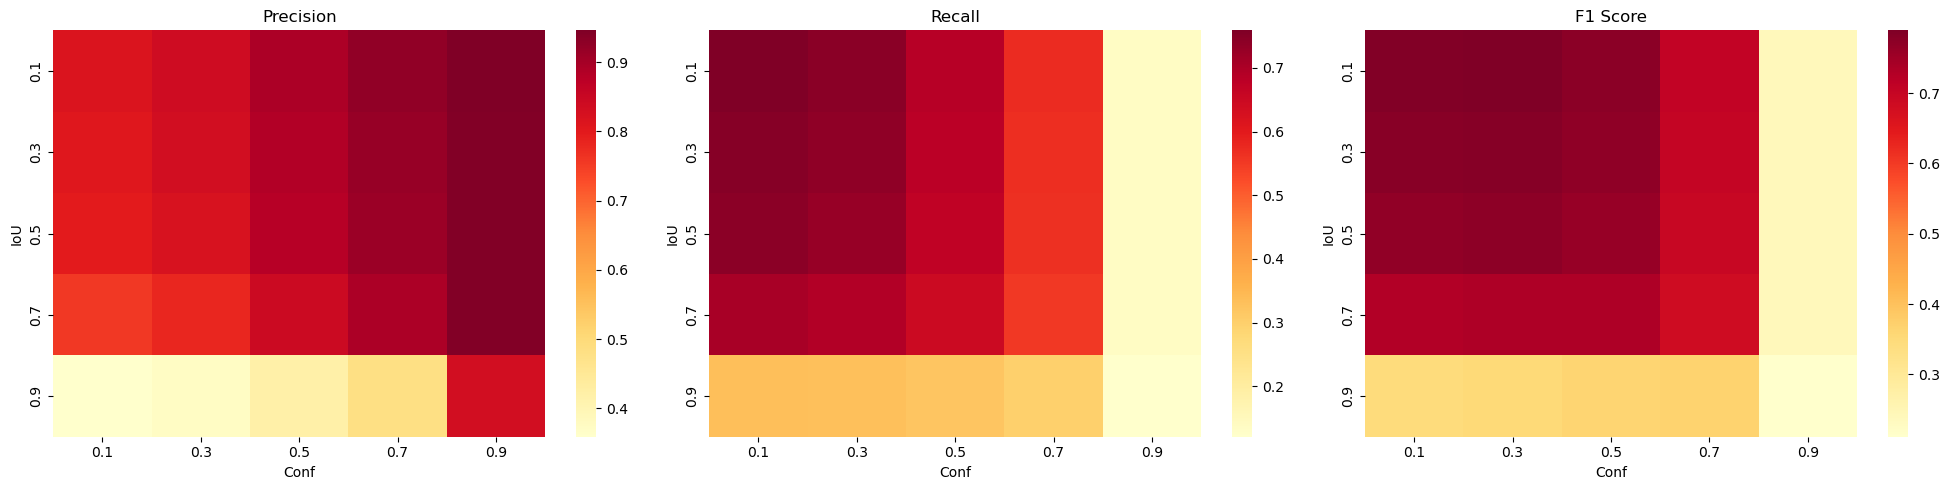

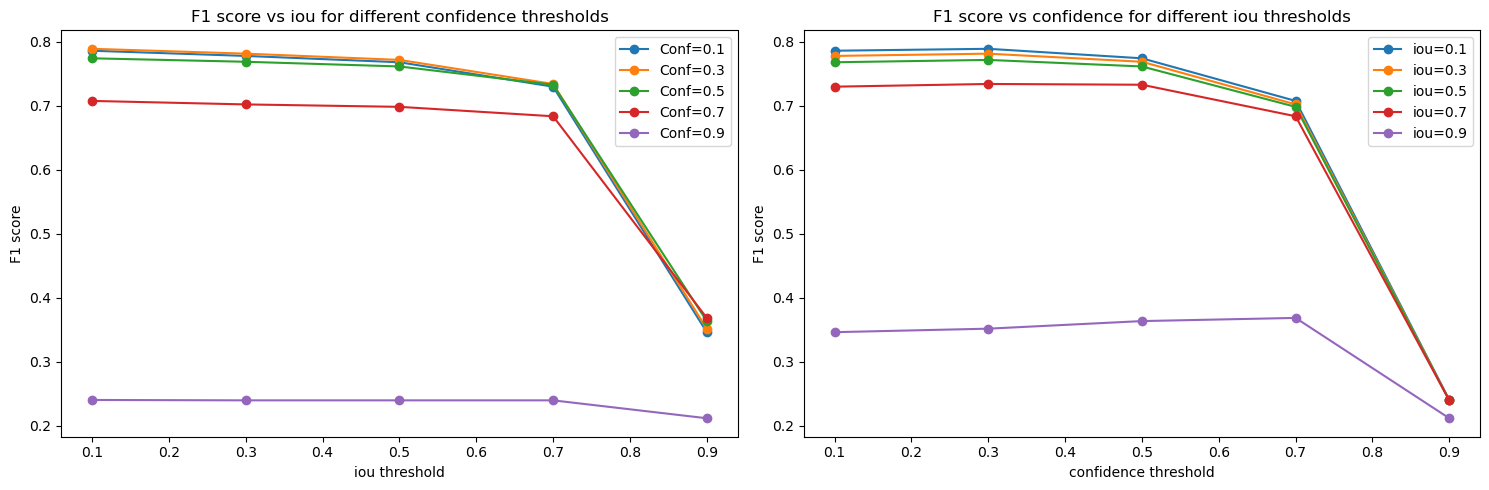

In [189]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
precision = df.pivot(index='IoU', columns='Conf', values='Precision')
recall = df.pivot(index='IoU', columns='Conf', values='Recall')
f1 = df.pivot(index='IoU', columns='Conf', values='F1')
sns.heatmap(precision, cmap='YlOrRd', ax=ax1)
sns.heatmap(recall, cmap='YlOrRd', ax=ax2)
sns.heatmap(f1, cmap='YlOrRd', ax=ax3)

ax1.set_title('Precision')
ax2.set_title('Recall')
ax3.set_title('F1 Score')

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for conf in df['Conf'].unique():
    confs = df[df['Conf'] == conf]
    ax1.plot(confs['IoU'], confs['F1'], marker='o', label=f'Conf={conf}')

ax1.set_xlabel('iou threshold')
ax1.set_ylabel('F1 score')
ax1.set_title('F1 score vs iou for different confidence thresholds')
ax1.legend()

for iou in df['IoU'].unique():
    ious = df[df['IoU'] == iou]
    ax2.plot(ious['Conf'], ious['F1'], marker='o', label=f'iou={iou}')

ax2.set_xlabel('confidence threshold')
ax2.set_ylabel('F1 score')
ax2.set_title('F1 score vs confidence for different iou thresholds')
ax2.legend()

plt.tight_layout()
plt.show()

In [190]:
map_metrics = sv.MeanAveragePrecision.from_tensors(
    predictions=preds,
    targets=tgs
)
sv_map50 = map_metrics.map50

my_pr = []
my_rc = []
for pred, target in zip(preds, tgs):
    if len(pred) == 0 or len(target) == 0:
        my_pr.append(np.array([0.0]))
        my_rc.append(np.array([0.0]))
    else:
        p, r = eval(target[:, :4], pred[:, :4], pred[:, 5], iou_thresh=0.5)
        my_pr.append(p)
        my_rc.append(r)

my_map50 = np.mean([AP(p, r) for p, r in zip(my_pr, my_rc)]) if my_pr else 0.0

print(f"Supervision mAP50: {sv_map50:.4f}")
print(f"Custom mAP50: {my_map50:.4f}")

Supervision mAP50: 0.7858
Custom mAP50: 0.7442


In [194]:
n = 6
test = list(Path(test_dir).glob('*.tif'))
test = np.random.choice(test, n, replace=False)

imgs= []
for img in test:
    label_path = str(img).replace('images', 'labels').replace('.tif', '.txt')
    pred = model(str(img))[0]
    
    imgs.append({
        'image_path': str(img),
        'label_path': label_path,
        'predictions': pred
    })


image 1/1 c:\Users\Arjun\Desktop\Solar Yolo\data\test\images\solarpanels_native_2__x0_5823_y0_5890_dxdy_416.tif: 416x416 3 sps, 101.8ms
Speed: 1.6ms preprocess, 101.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\Arjun\Desktop\Solar Yolo\data\test\images\solarpanels_native_2__x0_2669_y0_5103_dxdy_416.tif: 416x416 39 sps, 144.4ms
Speed: 0.0ms preprocess, 144.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\Arjun\Desktop\Solar Yolo\data\test\images\solarpanels_native_2__x0_9928_y0_2055_dxdy_416.tif: 416x416 1 sp, 97.6ms
Speed: 0.0ms preprocess, 97.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\Arjun\Desktop\Solar Yolo\data\test\images\solarpanels_native_2__x0_928_y0_10494_dxdy_416.tif: 416x416 60 sps, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\Arjun\Desktop\Solar Yolo\data\test\images

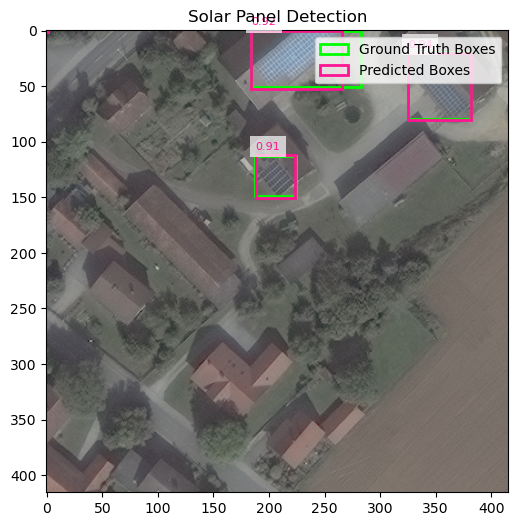

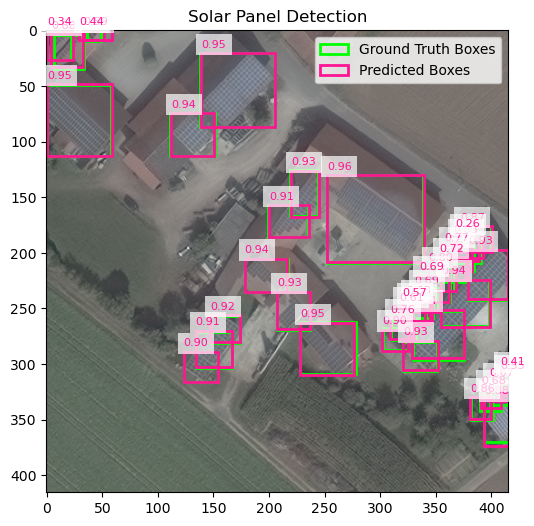

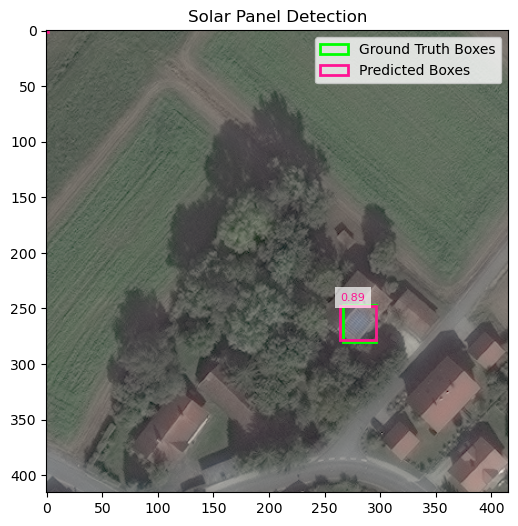

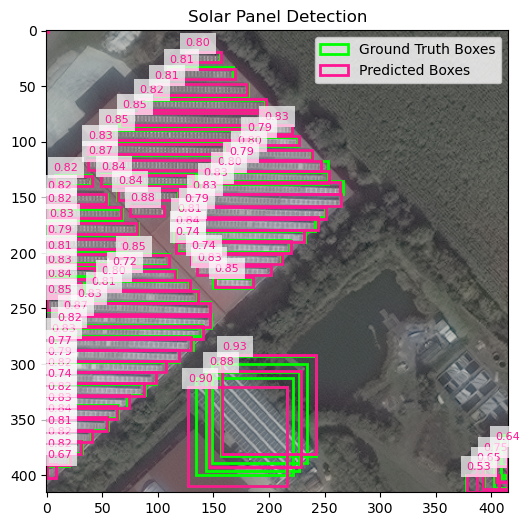

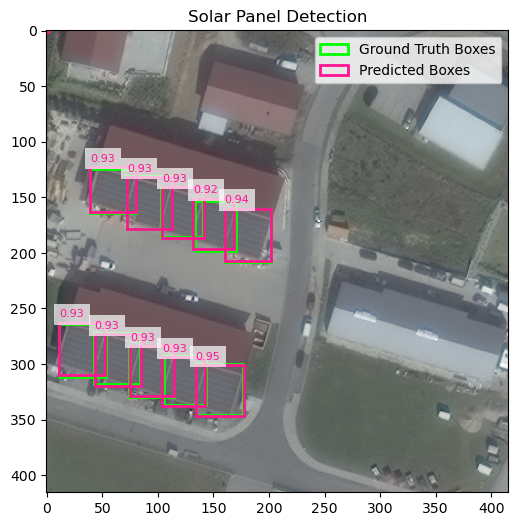

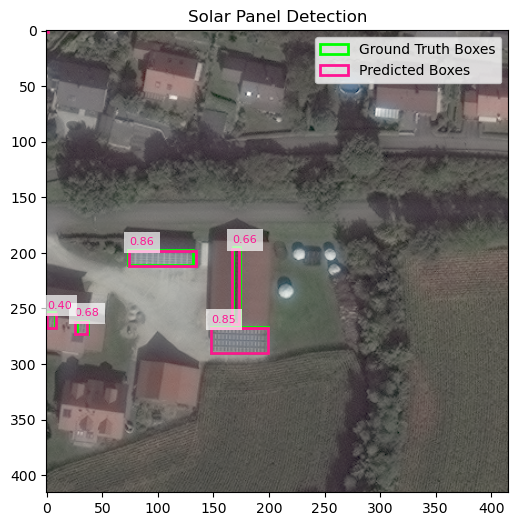

In [195]:
for idx, result in enumerate(imgs):
    subfig, subax = plot(
        result['image_path'], 
        result['label_path'],
        result['predictions']
    )